# بسم الله الرحمن الرحيم

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

In [6]:
with zipfile.ZipFile('/content/drive/MyDrive/Data set/Shop DataSet.zip','r') as file :
  file.extractall('/content/Data set')

In [7]:
dataset = {}
datapath = '/content/Data set/Shop DataSet'

for filename in os.listdir(datapath):
  videos_paths = []
  for video_name in os.listdir(os.path.join(datapath,filename)):
    videos_paths.append(os.path.join(datapath,filename,video_name))
  dataset[filename] = videos_paths


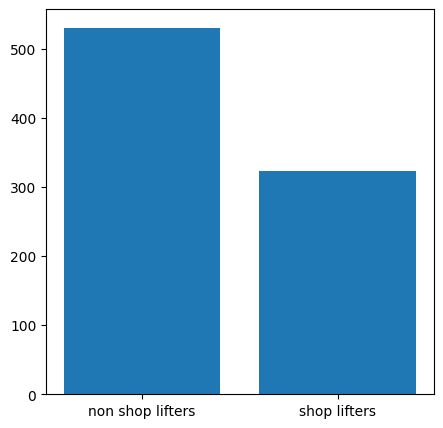

In [8]:
plt.figure(figsize=(5,5))
plt.bar(dataset.keys(), [len(videos) for videos in dataset.values()])
plt.show()

In [9]:
data_list = []
for category, videos in dataset.items():
    for video_path in videos:
        data_list.append({'labels': category, 'Video Path': video_path})

df_videos = pd.DataFrame(data_list)
df_videos

,labels,Video Path
0,non shop lifters,/content/Data set/Shop DataSet/non shop lifter...
1,non shop lifters,/content/Data set/Shop DataSet/non shop lifter...
2,non shop lifters,/content/Data set/Shop DataSet/non shop lifter...
3,non shop lifters,/content/Data set/Shop DataSet/non shop lifter...
4,non shop lifters,/content/Data set/Shop DataSet/non shop lifter...
...,...,...
850,shop lifters,/content/Data set/Shop DataSet/shop lifters/vi...
851,shop lifters,/content/Data set/Shop DataSet/shop lifters/vi...
852,shop lifters,/content/Data set/Shop DataSet/shop lifters/vi...
853,shop lifters,/content/Data set/Shop DataSet/shop lifters/vi...


Minority class: shop lifters with 324 samples
Majority class: non shop lifters with 531 samples

Class distribution after oversampling:
labels
non shop lifters    531
shop lifters        531
Name: count, dtype: int64


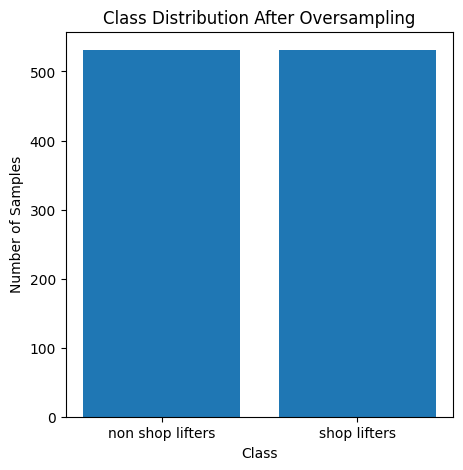

In [10]:
# Identify the minority and majority classes
class_counts = df_videos['labels'].value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
minority_count = class_counts[minority_class]
majority_count = class_counts[majority_class]

print(f"Minority class: {minority_class} with {minority_count} samples")
print(f"Majority class: {majority_class} with {majority_count} samples")

# Separate minority and majority class samples
df_minority = df_videos[df_videos['labels'] == minority_class]
df_majority = df_videos[df_videos['labels'] == majority_class]

# Randomly duplicate minority class samples
df_minority_oversampled = df_minority.sample(majority_count, replace=True, random_state=42)

# Concatenate the oversampled minority class with the majority class
df_oversampled = pd.concat([df_majority, df_minority_oversampled], axis=0)

# Shuffle the oversampled dataset
df_oversampled = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nClass distribution after oversampling:")
print(df_oversampled['labels'].value_counts())

oversampled_class_counts = df_oversampled['labels'].value_counts()
plt.figure(figsize=(5,5))
plt.bar(oversampled_class_counts.index, oversampled_class_counts.values)
plt.title('Class Distribution After Oversampling')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_oversampled['labels'] = le.fit_transform(df_oversampled['labels'])
df_oversampled

,labels,Video Path
0,0,/content/Data set/Shop DataSet/non shop lifter...
1,0,/content/Data set/Shop DataSet/non shop lifter...
2,1,/content/Data set/Shop DataSet/shop lifters/sh...
3,1,/content/Data set/Shop DataSet/shop lifters/vi...
4,1,/content/Data set/Shop DataSet/shop lifters/vi...
...,...,...
1057,0,/content/Data set/Shop DataSet/non shop lifter...
1058,0,/content/Data set/Shop DataSet/non shop lifter...
1059,0,/content/Data set/Shop DataSet/non shop lifter...
1060,1,/content/Data set/Shop DataSet/shop lifters/sh...


In [12]:
def video_generator(df, frames_per_video=32, img_size=(224,224)):
    for _, row in df.iterrows():
        path = row['Video Path']
        label = row['labels']
        cap = cv2.VideoCapture(path)
        frames = []
        while len(frames) < frames_per_video:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, img_size)
            frame = frame[:, :, ::-1]            # BGR -> RGB
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)
        cap.release()
        # padding if short
        while len(frames) < frames_per_video:
            frames.append(np.zeros_like(frames[0], dtype=np.float32))
        yield np.array(frames, dtype=np.float32), np.int32(label)

# output signature (channels_last): (frames, H, W, C)
frames_per_video = 16
img_size = (224, 224)
output_signature = (
    tf.TensorSpec(shape=(frames_per_video, img_size[0], img_size[1], 3), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int32)
)

In [13]:
# split data into train, validation , and test
from sklearn.model_selection import train_test_split

# Split the oversampled DataFrame
train_df, test_df = train_test_split(df_oversampled, test_size=0.2, random_state=42)

# Create TensorFlow Datasets from the split DataFrames
train_ds = tf.data.Dataset.from_generator(
    lambda: video_generator(train_df, frames_per_video, img_size),
    output_signature=output_signature
)

test_ds = tf.data.Dataset.from_generator(
    lambda: video_generator(test_df, frames_per_video, img_size),
    output_signature=output_signature
)


# optional augmentation function (tf ops)
def augment(frames, label):
    # frames: (T,H,W,C)
    frames = tf.image.random_flip_left_right(frames)
    # you can add random crop, brightness, etc.
    return frames, label

# Apply augmentation to the training dataset
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch both datasets
train_ds = train_ds.batch(4).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(4).prefetch(tf.data.AUTOTUNE)

print("Training dataset:")
print(train_ds)
print("\nTesting dataset:")
print(test_ds)

Training dataset:
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing dataset:
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [14]:
base_cnn = ResNet101(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
base_cnn.trainable = False

cnn_out = GlobalAveragePooling2D()(base_cnn.output)
cnn_extractor = Model(base_cnn.input, cnn_out)

video_input = Input(shape=(frames_per_video, img_size[0], img_size[0], 3))
x = TimeDistributed(cnn_extractor)(video_input)

x = LSTM(256, return_sequences=False)(x)
x = tf.keras.layers.BatchNormalization()(x) # Added BatchNormalization
x = Dropout(0.5)(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(video_input, output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )
model.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 2048)       │    42,658,176 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,019,777 (171.74 MB)

 Trainable params: 2,361,089 (9.01 MB)

 Non-trainable params: 42,658,688 (162.73 MB)

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Reduced learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )

In [16]:
history = model.fit(
    train_ds,
    epochs=20 ,
    validation_data=test_ds
)

Epoch 1/20
    213/Unknown 347s 685ms/step - accuracy: 0.6054 - loss: 0.6789

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


213/213 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.6056 - loss: 0.6787 - val_accuracy: 0.5023 - val_loss: 1.3368
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 187s 867ms/step - accuracy: 0.7074 - loss: 0.5682 - val_accuracy: 0.4977 - val_loss: 3.0011
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 183s 860ms/step - accuracy: 0.7723 - loss: 0.5105 - val_accuracy: 0.4977 - val_loss: 3.0981
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 184s 865ms/step - accuracy: 0.7843 - loss: 0.4952 - val_accuracy: 0.5023 - val_loss: 51.5795
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 184s 863ms/step - accuracy: 0.7416 - loss: 0.5199 - val_accuracy: 0.5023 - val_loss: 30.3140
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 263s 868ms/step - accuracy: 0.8469 - loss: 0.3975 - val_accuracy: 0.5117 - val_loss: 4.1620
Epoch 7/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 184s 866ms/step - accuracy: 0.8355 - loss: 0.3887 - val_accuracy: 0.4977 - val_loss: 14.4893
Epoch 8/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 185s 866ms/step - accuracy: 0.8476 - loss: 0.38

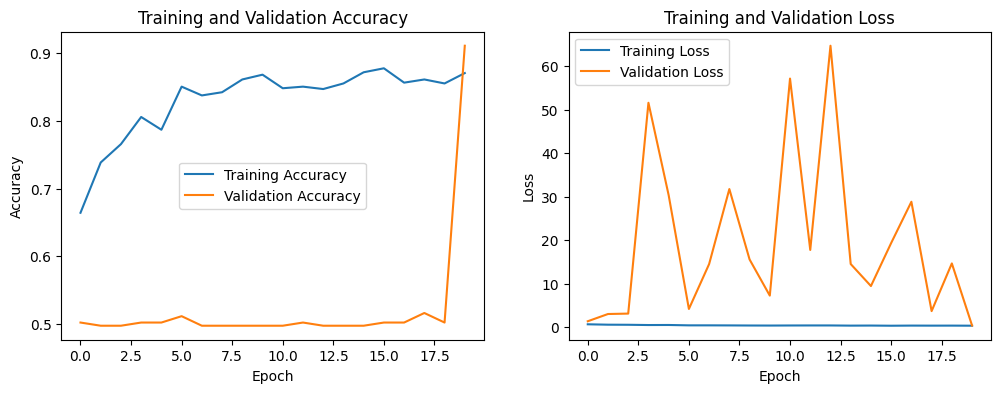

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
model.evaluate(test_ds)

54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 655ms/step - accuracy: 0.8933 - loss: 0.3512


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[0.3548244833946228, 0.9107981324195862]

In [19]:
# Save the model
model.save('shop_lifting_detection_model.h5')